### Process datafiles, 05.11


In [99]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
#import cv2
framerate = 29.18
from scipy import signal
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
#%cd "D:\Interfacial Waves resonance videos 0430"
framerate = 29.18



from matplotlib import rc
import matplotlib
#plt.switch_backend('agg')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.unicode']=True


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [10]:
frozen1 = np.loadtxt('data0509/0419_frozenFreqs.dat')
frozen2 = np.loadtxt('data0509/0509_frozenFreqs.dat')

In [11]:
def filterOnce(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)

    divs = np.abs(original-avg)> 2.5*std
    index = np.arange(0, len(original), 1)
    filtered[index[divs]] = filtered[index[divs]-1]
    #print(np.sum(divs))
    return filtered

def filterUntilSmooth(original):
    filtered = original.copy()
    avg = np.average(original)
    std = np.std(original)
    div = np.abs(original-avg) > 2.5*std
    while(np.sum(div)>0):
        filtered = filterOnce(filtered)
        avg = np.average(filtered)
        std = np.std(filtered)
        div = np.abs(filtered-avg)>2.5*std
    return filtered

def normalize(timeseries):
    avg = np.average(timeseries)
    stdev = np.std(np.abs(timeseries))
    return (timeseries-avg)/stdev


from scipy.ndimage.filters import uniform_filter

def window_stdev(arr, radius):
    padded = np.zeros(len(arr)+2*radius)
    padded[radius:-radius]= arr
    c1 = uniform_filter(padded, radius*2, mode='constant', origin=-radius)
    c2 = uniform_filter(padded*padded, radius*2, mode='constant', origin=-radius)
    return ((c2 - c1*c1)**.5)[:-radius*2+1]
def slidingStd(x, w):
    result = np.zeros_like(x)
    for index in range(len(x)):
#        print(index)
#        print(w)
#        print(min(w, index))
        windowlength = min(w, index)
        if(index>0):
            view = x[index-windowlength:index]
        else:
            view = x[0]
        result[index] = view.std()
    return result


def lin(x, a,b):
    return x*a+b


## Fitting the driving function

Short time FT in windows of 40 sec

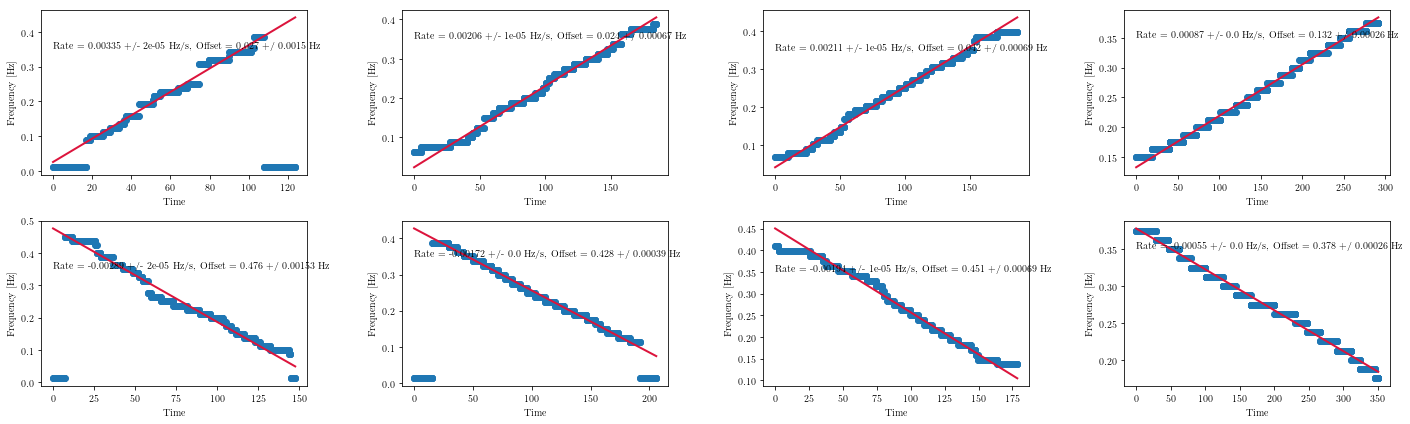

In [13]:
ramps = ['1__1_ramp', '1__2_ramp', '2__3_ramp', '1__5_ramp', 'neg1__1_ramp','neg1__2_ramp', 'neg2__3_ramp', 'neg1__5_ramp']
rampsData = {}
## diagnostics:
fig, axes = plt.subplots(2, 4, figsize=(20,6))
axeslist = axes.flatten()

for i,e in enumerate(ramps):
    dictionary = {}
    driving = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0509/2/driving/%s' %e, skiprows=2)
    fr = 1/(driving[1,0]-driving[0,0]) ##framerate
    from scipy import signal
    N = int(20*fr)
    
    ax = axeslist[i]
    f, t, Zxx = signal.stft(driving[:,1], fr, nperseg=500,noverlap=499, detrend='constant')
    dictionary['f'] = f
    dictionary['t'] = t
    dictionary['Zxx'] = Zxx
    dictionary['time'] = driving[:,0]
    dictionary['frequencies'] = f[np.argmax(np.abs(Zxx), axis=0)]
    popt, pcov = curve_fit(lin, t[N:-N], dictionary['frequencies'][N:-N])
    error = np.sqrt(np.diag(pcov))
    ax.plot(t, f[np.argmax(np.abs(Zxx), axis=0)], 'o')
    ax.plot(t, lin(t, *popt), '-', c='Crimson', linewidth=2.)
    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    #ax.set_title(e)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency [Hz]')
    dictionary['coeffs'] = popt
    dictionary['errors'] = error
    N = int(20*framerate)
    rampsData[e] = {}
    rampsData[e]['driving'] = dictionary
    rampsData[e]['surface'] = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0509/2/surface/%s' %e, skiprows=2)
    
fig.tight_layout()

## Reading interface position and width

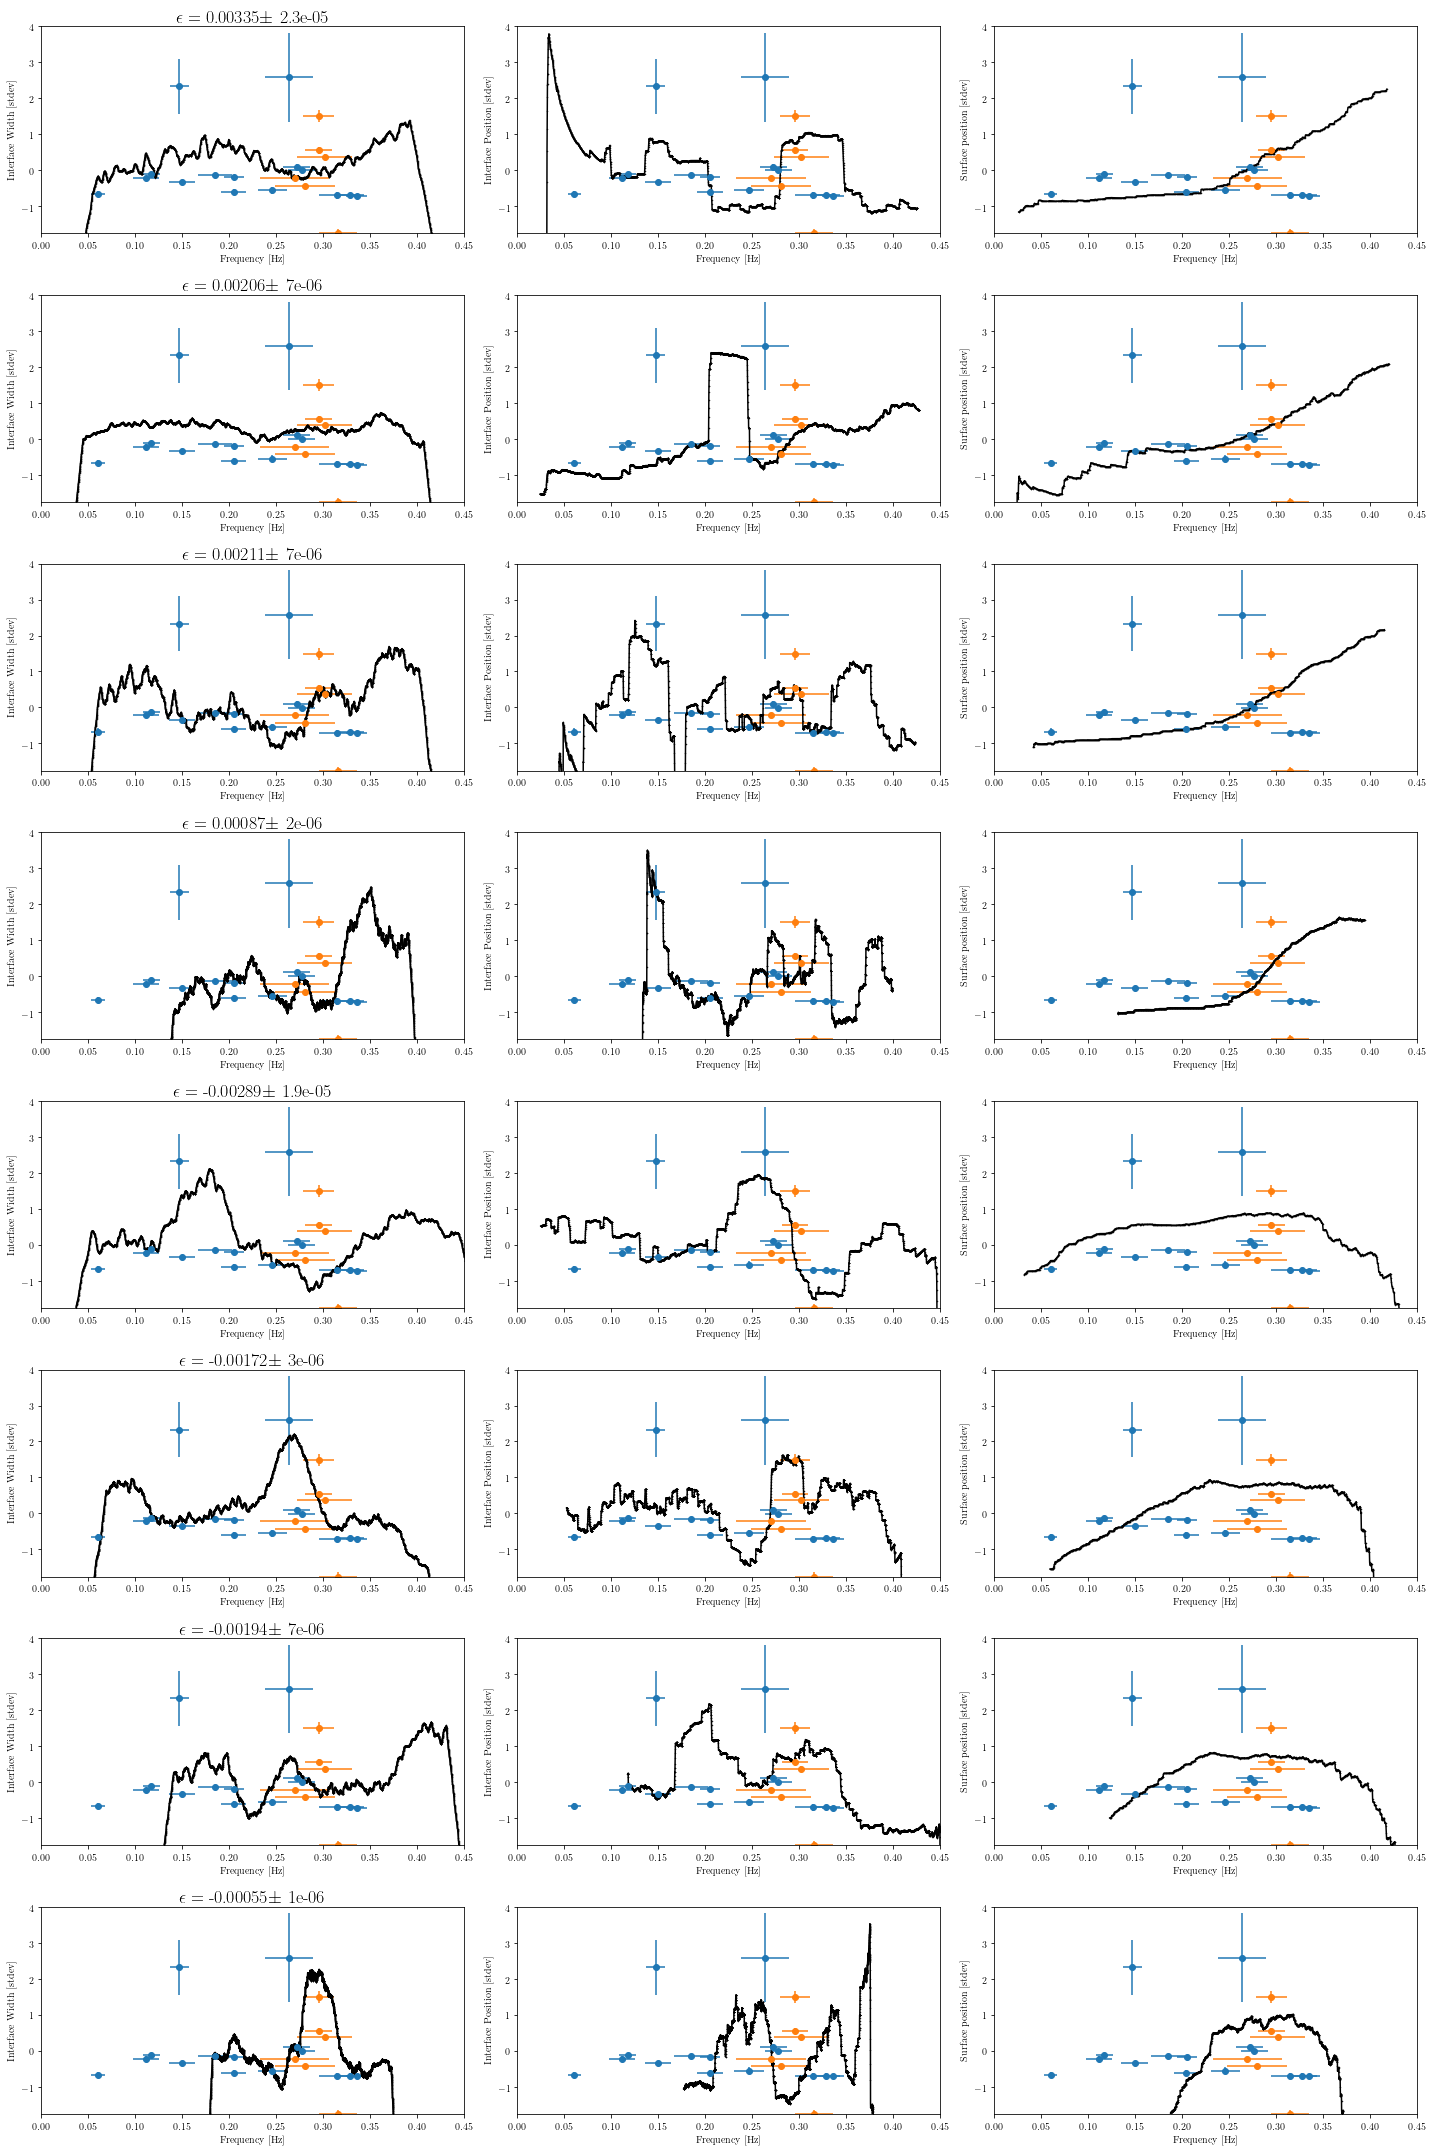

In [14]:
fig, axes = plt.subplots(8, 3, figsize=(20,30))
axeslist = axes.flatten()
ramps = ['1__1_ramp', '1__2_ramp', '2__3_ramp', '1__5_ramp', 'neg1__1_ramp','neg1__2_ramp', 'neg2__3_ramp', 'neg1__5_ramp']

for i,e in enumerate(rampsData.values()):
    N = int(20*framerate)
    data = np.loadtxt('C:/Users/balin/Docs/boSchlieren/data0509/2/%s' %ramps[i])
    #movingAvgI = np.convolve(data[i][:,0], np.ones((N,))/N, mode='same')
    movingAvgw = np.convolve(filterUntilSmooth(data[:,1]), np.ones((N,))/N, mode='same')
    #dictionary['movingAvg'] = movingAvgI
    dictionary['movingAvgw'] = normalize(movingAvgw)
    movingStdevIF = slidingStd(data[:,0], N)
    movingStdevSF = slidingStd(e['surface'][:,1], N)
    
    dictionary['position'] = normalize(movingStdevIF)
    dictionary['surfacePos'] = normalize(movingStdevSF)
    dictionary['time'] = np.arange(0., data.shape[0],1)/framerate
    ax = axes[:,0][i]
    ax2 = axes[:,1][i]
    ax3 = axes[:,2][i]
    ax.plot(lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs']), normalize(movingAvgw), '-o', c='black', markersize=0.5)
#    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax.set_ylim(np.min(frozen2[:,1]), 4.)
    ax.set_xlim(0., 0.45)
    ax.set_title("$\epsilon = $ %s$\pm$ %s" %(round(e['driving']['coeffs'][0], 5), round(e['driving']['errors'][0], 6)) , fontsize=18)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Interface Width [stdev]')
    #print(movingStdevSF)
    ax2.plot(lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs']), normalize(movingStdevIF), '-o', c='black', markersize=0.5)
    ax2.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax2.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax2.set_ylim(np.min(frozen2[:,1]), 4.)
    ax2.set_xlim(0., 0.45)
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Interface Position [stdev]')
    
    ax3.plot(lin(e['surface'][:,0], *e['driving']['coeffs']), normalize(movingStdevSF), '-o', c='black', markersize=0.5)
#    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax3.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax3.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax3.set_ylim(np.min(frozen2[:,1]), 4.)
    ax3.set_xlim(0., 0.45)
    ax3.set_xlabel('Frequency [Hz]')
    ax3.set_ylabel('Surface position [stdev]')
    e['interface'] = dictionary
    #allData[e] = dictionary
fig.tight_layout()

### 04.30

In [15]:
mediumRamp = np.loadtxt('data0430/MediumRamp.dat')
reverseRamp = np.loadtxt('data0430/reverseRamp.dat')
quickRamp = np.loadtxt('data0430/quickRamp.dat')
slowRamp = np.loadtxt('data0430/slowRamp.dat')


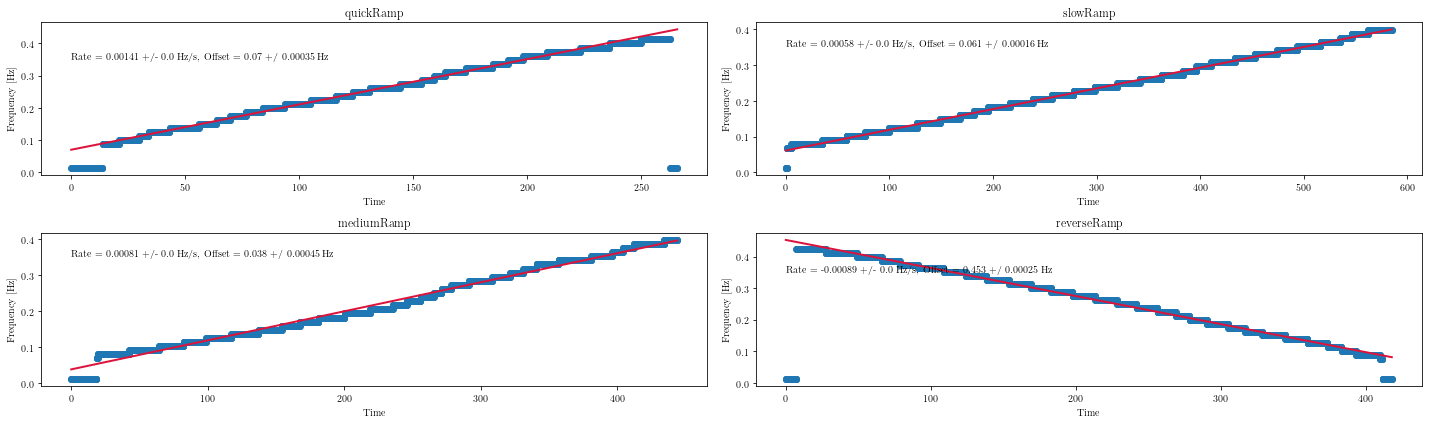

In [16]:
ramps = ['quickRamp', 'slowRamp','mediumRamp', 'reverseRamp']
data = [quickRamp, slowRamp, mediumRamp, reverseRamp]
rampsDataOld = {}
fig, axes = plt.subplots(2, 2, figsize=(20,6))
axeslist = axes.flatten()

for i,e in enumerate(ramps):
    dictionary = {}
    driving = np.loadtxt('data0430/driving/%s' %e, skiprows=2)
    fr = 1/(driving[1,0]-driving[0,0]) ##framerate
    from scipy import signal
    N = int(20*fr)
    
    ax = axeslist[i]
    f, t, Zxx = signal.stft(driving[:,1], fr, nperseg=500,noverlap=499, detrend='constant')
    dictionary['f'] = f
    dictionary['t'] = t
    dictionary['Zxx'] = Zxx
    dictionary['frequencies'] = f[np.argmax(np.abs(Zxx), axis=0)]
    popt, pcov = curve_fit(lin, t[N:-N], dictionary['frequencies'][N:-N])
    error = np.sqrt(np.diag(pcov))
    ax.plot(t, f[np.argmax(np.abs(Zxx), axis=0)], 'o')
    ax.plot(t, lin(t, *popt), '-', c='Crimson', linewidth=2.)
    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax.set_title(e)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency [Hz]')

    dictionary['coeffs'] = popt
    dictionary['errors'] = error
    N = int(20*framerate)
    rampsDataOld[e] = {}
    rampsDataOld[e]['driving'] = dictionary
    rampsDataOld[e]['surface'] = np.loadtxt('data0430/surfaceResponse//%s' %e, skiprows=2)
fig.tight_layout()

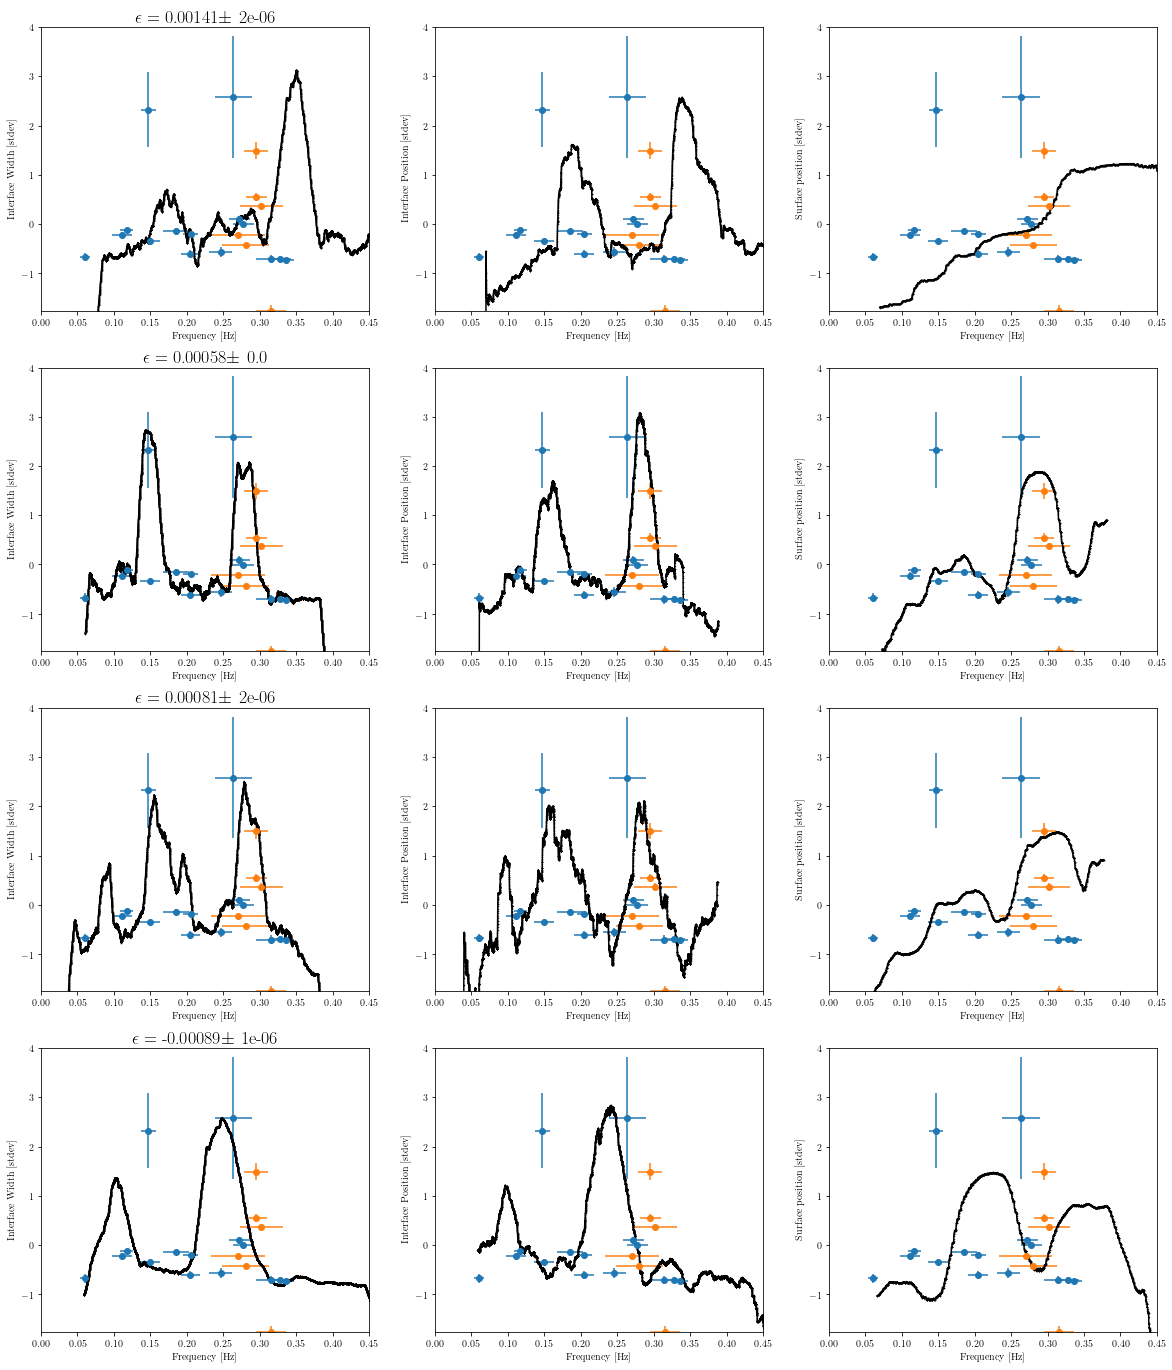

In [17]:
fig, axes = plt.subplots(4, 3, figsize=(20,24))
axeslist = axes.flatten()
ramps = ['quickRamp', 'slowRamp','mediumRamp', 'reverseRamp']

for i,e in enumerate(rampsDataOld.values()):
    N = int(20*framerate)
    data = np.loadtxt('data0430/%s.dat' %ramps[i])
    #movingAvgI = np.convolve(data[i][:,0], np.ones((N,))/N, mode='same')
    movingAvgw = np.convolve(filterUntilSmooth(data[:,1]), np.ones((N,))/N, mode='same')
    #dictionary['movingAvg'] = movingAvgI
    dictionary['movingAvgw'] = movingAvgw
    movingStdevIF = slidingStd(data[:,0], N)
    movingStdevSF = slidingStd(e['surface'][:,1], N)
    
    dictionary['position'] = normalize(movingStdevIF)
    dictionary['surfacePos'] = normalize(movingStdevSF)
    dictionary['time'] = np.arange(0., data.shape[0],1)/framerate
    ax = axes[:,0][i]
    ax2 = axes[:,1][i]
    ax3 = axes[:,2][i]

    ax.plot(lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs']), normalize(movingAvgw), '-o', c='black', markersize=0.5)
#    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax.set_ylim(np.min(frozen2[:,1]), 4.)
    ax.set_xlim(0., 0.45)
    ax.set_title("$\epsilon = $ %s$\pm$ %s" %(round(e['driving']['coeffs'][0], 5), round(e['driving']['errors'][0], 6)) , fontsize=18)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Interface Width [stdev]')
    ax2.plot(lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs']), normalize(movingStdevIF), '-o', c='black', markersize=0.5)
    ax2.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax2.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax2.set_ylim(np.min(frozen2[:,1]), 4.)
    ax2.set_xlim(0., 0.45)
    ax2.set_xlabel('Frequency [Hz]')
    ax2.set_ylabel('Interface Position [stdev]')
    
    ax3.plot(lin(e['surface'][:,0], *e['driving']['coeffs']), normalize(movingStdevSF), '-o', c='black', markersize=0.5)
#    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
    ax3.errorbar(frozen1[:,0], frozen1[:,1], fmt='o', xerr=frozen1[:,2], yerr=frozen1[:,3])
    ax3.errorbar(frozen2[:,0], frozen2[:,1], fmt='o', xerr=frozen2[:,2], yerr=frozen2[:,3])
    ax3.set_ylim(np.min(frozen2[:,1]), 4.)
    ax3.set_xlim(0., 0.45)
    ax3.set_xlabel('Frequency [Hz]')
    ax3.set_ylabel('Surface position [stdev]')
    #allData[e] = dictionar

In [ ]:

from scipy.ndimage.filters import uniform_filter

def window_stdev(arr, radius):
    c1 = uniform_filter(arr, radius*2, mode='constant', origin=-radius)
    c2 = uniform_filter(arr*arr, radius*2, mode='constant', origin=-radius)
    return ((c2 - c1*c1)**.5)[:-radius*2+1]



## Typical driving timeseries

In [ ]:
driving = np.loadtxt('data0430/driving/slowRamp', skiprows=2)
fr = 1/(driving[1,0]-driving[0,0]) ##framerate
from scipy import signal
N = int(20*fr)
f, t, Zxx = signal.stft(driving[:,1], fr, nperseg=3*N,noverlap=3*N-1, detrend='constant')
ratio = 8./6.

frequencies = f[np.argmax(np.abs(Zxx), axis=0)]
popt, pcov = curve_fit(lin, t[N:-N], frequencies[N:-N])
error = np.sqrt(np.diag(pcov))


fig = plt.figure()
plt.plot(driving[:,0], driving[:,1], '-o', markersize=0.1, linewidth= 0.2)
plt.xlabel("$t$")
plt.ylabel('Gerjesztési amplitúdó [pixel]')
fig.set_size_inches(3.5*2, 3.5/ratio)
plt.savefig('runUp1.pdf', bbox_inches='tight')
plt.clf()

fig, (ax2, ax3) = plt.subplots(1, 2)

ax2.pcolormesh(t, f, np.abs(Zxx), rasterized=True)
ax2.set_ylim(0., 1.)
ax2.set_xlabel('Idő [s]')
ax2.set_ylabel('Gerjesztési frekvencia [Hz]')

ax3.plot(t, f[np.argmax(np.abs(Zxx), axis=0)], 'o')
ax3.plot(t, lin(t, *popt), '-', c='Crimson', linewidth=2.)
ax3.set_xlabel('Idő [s]')
ax3.set_ylabel('Gerjesztési frekvencia [Hz]')

fig.set_size_inches(2*3.5, 3.5/ratio)
fig.tight_layout()
plt.savefig('runUp.pdf', bbox_inches='tight')
plt.show()

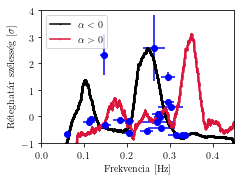

In [21]:
N = int(20*framerate)
f = plt.figure()
data = np.loadtxt('data0430/reverseRamp.dat')
#movingAvgI = np.convolve(data[i][:,0], np.ones((N,))/N, mode='same')
movingAvgw = np.convolve(filterUntilSmooth(data[:,1]), np.ones((N,))/N, mode='same')
#dictionary['movingAvg'] = movingAvgI
e = rampsDataOld['reverseRamp']

plt.plot(lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs']), normalize(movingAvgw), '-o', c='black', markersize=0.5, label = r'$\alpha<0$')
#    ax.text(0., 0.35, r'Rate = %s +/- %s Hz/s, Offset = %s +/ %s Hz' %(round(popt[0], 5), round(error[0], 5), round(popt[1], 3), round(error[1], 5)))
plt.errorbar(frozen1[:,0], frozen1[:,1], fmt='o',c='blue', xerr=frozen1[:,2], yerr=frozen1[:,3])
plt.errorbar(frozen2[:,0], frozen2[:,1], fmt='o',c='blue', xerr=frozen2[:,2], yerr=frozen2[:,3])

N = int(20*framerate)
data = np.loadtxt('data0430/quickRamp.dat')
#movingAvgI = np.convolve(data[i][:,0], np.ones((N,))/N, mode='same')
movingAvgw = np.convolve(filterUntilSmooth(data[:,1]), np.ones((N,))/N, mode='same')
#dictionary['movingAvg'] = movingAvgI
e = rampsDataOld['quickRamp']

plt.plot(lin(np.arange(0., movingAvgw.shape[0],1)/framerate, *e['driving']['coeffs']), normalize(movingAvgw), '-o', c='Crimson', markersize=0.5, label = r'$\alpha>0$')


plt.ylim(-1, 4.)
plt.xlim(0., 0.45)
plt.legend(loc='upper left')
plt.xlabel('Frekvencia [Hz]')
plt.ylabel('Réteghatár szélesség [$\sigma$]')
f.set_size_inches(3.5, 3.5/ratio)
f.tight_layout()
plt.savefig('odaVissza.pdf')